# A beginner-friendly implementation of the VQE with qiskit 1.0 (Part 2)

## Introduction

This notebook is the second part of my project introducing the VQE for beginners. In the [first part](https://sites.google.com/view/bentomontenegro/tutorials?authuser=0) we considered the Hamiltonian $H = Z$ and now we move to the (slightly) more complicated case of the Hamiltonian $H = Z - X$. If you have not checked the first part, I recommend you to take a brief look at it in order to clarify our code and our notation.

Of course, this second problem is also one for which the answer can be obtained for the sake of comparison, as one can easily show (using standard linear algebra methods) that the eigenvalues of
\begin{equation}
    H =
    \begin{pmatrix}
    1 & -1 \\
    -1 & -1
    \end{pmatrix}
\end{equation}
are $\pm \sqrt{2}$ (the eigenstates are not important for now). Hence, the answer we wish to abtain with the VQE is as close as possible to $E_0 = - \sqrt{2}$.

## Building the Ansatz as two quantum circuits

Let us define $H_1 = Z$ and $H_2 = X$, so that $H = H_1 - H_2$. The basic difference from part 1 and now is that, in the second case, as the Hamiltonian has two terms, we need to define a further parameterized 1-qubit quantum circuit. Hopefully the code is clear enough.

In [8]:
### Parameterized Ansätze

from numpy import pi
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter

## Ansatz for H1 = Z
qc_1 = QuantumCircuit(1) # 1-qubit quantum circuit
theta_1 = Parameter('theta_1') # Azhimutal angle
phi_1 = Parameter('phi_1') # Polar angle
qc_1.ry(theta_1, 0) # Parameterized y-rotation
qc_1.rz(phi_1, 0) # Parameterized z-rotation
qc_1.measure_all()

## Ansatz for H2 = X
qc_2 = QuantumCircuit(1) # 1-qubit quantum circuit
theta_2 = Parameter('theta_2') # Azhimutal angle
phi_2 = Parameter('phi_2') # Polar angle
qc_2.ry(theta_2, 0) # Parameterized y-rotation
qc_2.rz(phi_2, 0) # Parameterized z-rotation
qc_2.ry(-pi/2, 0) # Changing to the x-basis
qc_2.measure_all()

Note that we need to define a different set of parameters for each quantum circuit. Usually this is done by implementing a _vector_ of parameters in qiskit, but our case is simple enough to proceed more directly.

Note also that at the end of the second quantum circuit we need to add a (non-parameterized) $R_Y(-\pi/2)$ standard rotation in order to turn the eigenstate basis of $X$, $\{|+\rangle, |-\rangle\}$, into the eigenstate basis of $Z$, $\{|0\rangle, |1\rangle\}$. This is necessary because quantum computers can only measure in the later basis. Conversely, if it was the case that $H_2 = Y$, for example, we would need to change from the eigenstates basis of $Z$ to the eigenstate basis of $Y$, $\{|+i\rangle, |-i\rangle\}$. This can be achieved with a $R_X(\pi/2)$ standard rotation. (Look at the Bloch sphere for a little while and recall the [right hand rule](https://pressbooks.library.upei.ca/statics/wp-content/uploads/sites/56/2021/03/Screen-Shot-2021-07-30-at-9.37.47-PM-1024x671.png) for standard rotations.)

<div style = "text-align: center;">
    <img src = "Bloch.png" style = "width:250px; height:260px"/>
</div>

## Implementing the VQE

### Expectation values

As the standard $R_Y(-\pi/2)$ rotation take account of mapping the eigenstates of $X$ into the eigenstates of $Z$, we can use the same function of [part 1](ADD LINK) to calculate measurement outcomes.

In [9]:
### Function to return expectation values from a given Ansatz

from qiskit import transpile
from qiskit_aer import Aer

## Backend to return measurement counts
backend = Aer.get_backend('qasm_simulator')

## Function that returns 1 (-1) if the input is 0 (1)
def Z_eigenvalue(measurement_outcome):
    if measurement_outcome == '0':
        return 1
    else: return -1

## Function that simulates a qc and returns the expectation value of the Pauli operator Z
def ansatz_expectation(ansatz_qc, simulation_shots):
    
    ## Simulating the circuit
    transpiled_ansatz = transpile(ansatz_qc, backend)
    result = backend.run(transpiled_ansatz, shots = simulation_shots).result()
    result_counts = result.get_counts()

    ## Calculating the expectation value of Z
    expectation = 0.0
    for outcome, counts in result_counts.items():
        expectation += Z_eigenvalue(outcome)*counts

    return expectation/simulation_shots

In [3]:
### Function to return expectation values from a given Ansatz

from qiskit import transpile
from qiskit_aer import Aer

## Backend to return measurement counts
backend = Aer.get_backend('qasm_simulator')

## Function that returns 1 (-1) if the input is 0 (1)
def Z_eigenvalue(measurement_outcome):
    if measurement_outcome == '0':
        return 1
    else: return -1

## Function that simulates a qc and returns the expectation value of the Pauli operator Z
def ansatz_expectation(ansatz_qc, simulation_shots):
    
    ## Simulating the circuit
    transpiled_ansatz = transpile(ansatz_qc, backend)
    result = backend.run(transpiled_ansatz, shots = simulation_shots).result()
    result_counts = result.get_counts()

    ## Calculating the expectation value of Z
    expectation = 0.0
    for outcome, counts in result_counts.items():
        expectation += Z_eigenvalue(outcome)*counts

    return expectation/simulation_shots

I found simpler to use the `Aer` simulator in this case, but you can use the `BasicAer` or any other simulator that happens to return the number of measurement outcomes of a given circuit. Note that, because a quantum computer is a machine that rotates qubits and necessarily measure them at the end, we must pass the additional argument `simulation_shots` in order to make an _ensamble_ (= collection) of measurements to determine mean values such as $\langle H \rangle$. Recall that we have no direct access to superposition states: quantum mechanics tells that only "single" states can be the outcome of any measurement. I know this sounds rather philosophical, but in fact it is. According to the so-called Copenhagen interpretation (due to Bohr, Heisenberg, Dirac, Pauli et al.), single states are reality, whereas superpositions seems to be the simplest _language_ to describe reality (see the classical double-slit experiment).

### Optimum parameters

Exactly as we did in part 1, the _gradient-descent_ method is our friend to search for our optimum set of parameters (i.e. the set of parameters that minimize $\langle H \rangle$). Note that we need to use the _same_ set for each term in our Hamiltonian, that is, we define a separate quantum circuit for each term but we _do not minimize each term separately_.

In [10]:
### Minimizing H = Z - X

from numpy import linspace, append

## Choosing random initial parameters
theta_gs = pi/4
phi_gs = pi/3
shots = 1e4

## Arrays to store optimum parameter values
theta_array = [theta_gs]
phi_array = [phi_gs]

## Initial < H >

E_gs = ansatz_expectation(qc_1.assign_parameters({theta_1: theta_gs, phi_1: phi_gs}), shots) - ansatz_expectation(qc_2.assign_parameters({theta_2: theta_gs, phi_2: phi_gs}), shots)
E_array = [E_gs]

## Loop parameters
dtheta = dphi = 0.1
num_iteractions = 50 # Number of optimization trials

## Optimization loop (gradient-descent method)

for iteraction in range(num_iteractions):
    
    ## Components of grad_E
    grad_E_theta = ansatz_expectation(qc_1.assign_parameters({theta_1: theta_gs + dtheta, phi_1: phi_gs}), shots) - ansatz_expectation(qc_2.assign_parameters({theta_2: theta_gs + dtheta, phi_2: phi_gs}), shots) - E_gs
    grad_E_phi = ansatz_expectation(qc_1.assign_parameters({theta_1: theta_gs, phi_1: phi_gs + dphi}), shots) - ansatz_expectation(qc_2.assign_parameters({theta_2: theta_gs, phi_2: phi_gs + dphi}), shots) - E_gs

    ## Updating parameters
    theta_gs -= grad_E_theta
    phi_gs -= grad_E_phi

    ## New gs-energy
    E_gs = ansatz_expectation(qc_1.assign_parameters({theta_1: theta_gs, phi_1: phi_gs}), shots) - ansatz_expectation(qc_2.assign_parameters({theta_2: theta_gs, phi_2: phi_gs}), shots)
    E_array.append(E_gs)
    
    ## Storing theta_gs's and phi_gs's
    theta_array.append(theta_gs)
    phi_array.append(phi_gs)

    print(iteraction, '%.2f'%theta_gs, '%.2f'%phi_gs, '| E_gs = %.4f'%E_gs) # Uncoment this line if you want to watch the progress
    

0 0.91 0.99 | E_gs = 0.1620
1 0.99 0.90 | E_gs = 0.0548
2 1.13 0.86 | E_gs = -0.1628
3 1.25 0.79 | E_gs = -0.3466
4 1.36 0.73 | E_gs = -0.5108
5 1.50 0.65 | E_gs = -0.7370
6 1.58 0.57 | E_gs = -0.8376
7 1.69 0.52 | E_gs = -0.9910
8 1.77 0.46 | E_gs = -1.0910
9 1.85 0.41 | E_gs = -1.1456
10 1.93 0.37 | E_gs = -1.2298
11 1.97 0.33 | E_gs = -1.2520
12 2.03 0.30 | E_gs = -1.2968
13 2.08 0.27 | E_gs = -1.3302
14 2.10 0.25 | E_gs = -1.3450
15 2.12 0.23 | E_gs = -1.3566
16 2.15 0.21 | E_gs = -1.3590
17 2.17 0.17 | E_gs = -1.3688
18 2.20 0.15 | E_gs = -1.3996
19 2.20 0.11 | E_gs = -1.3796
20 2.23 0.14 | E_gs = -1.3734
21 2.26 0.15 | E_gs = -1.3886
22 2.30 0.14 | E_gs = -1.4132
23 2.29 0.12 | E_gs = -1.4014
24 2.29 0.11 | E_gs = -1.3958
25 2.31 0.09 | E_gs = -1.4236
26 2.29 0.07 | E_gs = -1.4056
27 2.29 0.06 | E_gs = -1.4086
28 2.29 0.05 | E_gs = -1.4012
29 2.29 0.06 | E_gs = -1.3970
30 2.33 0.05 | E_gs = -1.4178
31 2.33 0.04 | E_gs = -1.4080
32 2.32 0.04 | E_gs = -1.4232
33 2.33 0.03 | E_gs = 

As we know the right answer, let us calculate the error, $\epsilon$, associated with our simulation.

In [14]:
from numpy import sqrt

E_gs_analytical = -sqrt(2)

error = (E_gs_analytical - E_gs)/E_gs_analytical

print(error)

0.007646343282799286


It is a general fact from the VQE that if we perform $1/\epsilon^2$ measurements, we usually obtain an error of order $\epsilon$ (see [this article](https://arxiv.org/abs/2111.05176)). Thus, as we perfomed $10^4$ shots when measuring our quantum circuits in the above code, our error is approximately of order $10^{-2}$.

## Analysis of the process

As we did in part 1, let us visualize our search path through the $\theta \phi$-plane.

([<matplotlib.axis.YTick at 0x12fb31d90>],
 [Text(0, -0.025602448803402456, '−0.026')])

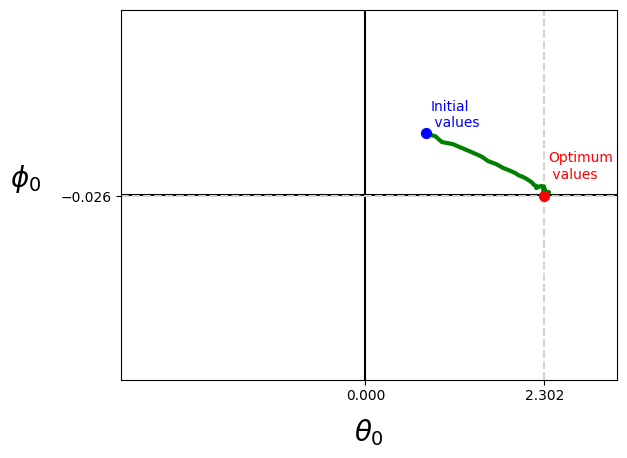

In [16]:
from numpy import zeros, linspace
from matplotlib.pyplot import plot, scatter, xlim, ylim, xlabel, ylabel, xticks, yticks, text

## Plotting x and y axis
plot(linspace(-pi, pi + 0.1, num_iteractions + 1), zeros(num_iteractions + 1), color = 'black') # Horizontal axis line
plot(zeros(num_iteractions + 1), linspace(-pi, pi, num_iteractions + 1),color = 'black') # Vertical axis line

## Plotting two dashed grey lines for reference
plot(zeros(num_iteractions + 1) + theta_array[num_iteractions], linspace(-pi, pi, num_iteractions + 1), color = 'lightgrey', linestyle = 'dashed')
plot(linspace(-pi, pi + 0.1, num_iteractions + 1), zeros(num_iteractions + 1) + phi_array[num_iteractions], color = 'lightgrey', linestyle = 'dashed')

## Plotting our curve of optimum parameters
plot(theta_array, phi_array, color = 'green', zorder = 2, linewidth = 3)

## Plot a red dot on optimum values
scatter(theta_array[0], phi_array[0], color = 'blue', marker = 'o', s = 50, zorder = 3)
text(theta_array[0] + 0.05, phi_array[0] + 0.1, 'Initial\n values', color = 'blue', fontsize = 10)
scatter(theta_array[num_iteractions], phi_array[num_iteractions], color = 'red', marker = 'o', s = 50, zorder = 3)
text(theta_array[num_iteractions] + 0.05, phi_array[num_iteractions] + 0.3, 'Optimum\n values', color = 'red', fontsize = 10)

## Personalizing the plot for clearer visualization
xlim(-pi, pi + 0.1)
ylim(-pi, pi)
xlabel(r'$\theta_0$', fontsize = 20, labelpad = 10)
ylabel(r'$\phi_0$', fontsize = 20, rotation = 0, labelpad = 25)
xticks([0, theta_array[num_iteractions]])
yticks([phi_array[num_iteractions]])


## Closing remarks

In this notebook we considered a slightly more complicated example of the VQE, confirming that the methods we used in part 1 lead to the right result. However, we have been restricted to the case of quantum circuits involving one qubit only. The case of more qubits is a natural generalization, and we shall implement it in a further notebook.